# Data exploration

source = https://www.kaggle.com/datasets/aniket0712/nypd-complaint-data-historic?resource=download

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime, date, time

# Data cleaning and preprocessing

In [27]:
data_folder = '../data/'
df = pd.read_csv(data_folder+'NYPD_Complaint_Data_Historic.csv', dtype={'CMPLNT_NUM': str})

In [28]:
df.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,JURISDICTION_CODE,PARKS_NM,HADEVELOPT,HOUSING_PSA,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,39468181,02/20/2008,07:00:00,02/23/2008,08:00:00,88.0,02/23/2008,107,BURGLARY,221.0,"BURGLARY,RESIDENCE,DAY",COMPLETED,FELONY,BROOKLYN,INSIDE,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,0,(null),(null),(null),991818.0,191560.0,(null),UNKNOWN,(null),NaN,40.692464,-73.972708,"(40.692464, -73.972708)",PATROL BORO BKLYN NORTH,(null),25-44,WHITE,F
1,50539499,08/21/2008,22:00:00,08/21/2008,23:00:00,19.0,08/22/2008,109,GRAND LARCENY,438.0,"LARCENY,GRAND FROM BUILDING (NON-RESIDENCE) UN...",COMPLETED,FELONY,MANHATTAN,FRONT OF,BAR/NIGHT CLUB,N.Y. POLICE DEPT,0,(null),(null),(null),997152.0,220300.0,(null),(null),(null),NaN,40.771341,-73.953418,"(40.771341, -73.953418)",PATROL BORO MAN NORTH,(null),45-64,WHITE HISPANIC,F
2,45223390,04/03/2008,03:35:00,04/03/2008,03:50:00,77.0,04/03/2008,106,FELONY ASSAULT,109.0,"ASSAULT 2,1,UNCLASSIFIED",COMPLETED,FELONY,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,2,(null),(null),3360,1004579.0,183837.0,(null),(null),(null),NaN,40.671245,-73.926713,"(40.671245, -73.926713)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F
3,50594658,08/19/2008,09:00:00,NaN,(null),32.0,08/27/2008,341,PETIT LARCENY,349.0,"LARCENY,PETIT OF LICENSE PLATE",COMPLETED,MISDEMEANOR,MANHATTAN,FRONT OF,STREET,N.Y. POLICE DEPT,0,(null),(null),(null),999965.0,235630.0,(null),UNKNOWN,(null),NaN,40.813412,-73.943226,"(40.813412, -73.943226)",PATROL BORO MAN NORTH,(null),(null),UNKNOWN,M
4,44451016,03/10/2008,22:00:00,03/10/2008,22:10:00,67.0,03/11/2008,105,ROBBERY,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",COMPLETED,FELONY,BROOKLYN,FRONT OF,STREET,N.Y. POLICE DEPT,0,(null),(null),(null),999602.0,176145.0,<18,BLACK,M,NaN,40.650142,-73.944674,"(40.650142, -73.944674)",PATROL BORO BKLYN SOUTH,(null),25-44,BLACK,M


In [29]:
print(f"We have {df.shape[0]:,} datapoints with {df.shape[1]} features")

We have 8,914,838 datapoints with 35 features


# NYPD Complaints 

| Column Name      | Description |
|-----------------|-------------|
| **CMPLNT_NUM**  | Unique identifier for each complaint |
| **CMPLNT_FR_DT** | Date when the incident started |
| **CMPLNT_FR_TM** | Time when the incident started |
| **CMPLNT_TO_DT** | Date when the incident ended (if applicable) |
| **CMPLNT_TO_TM** | Time when the incident ended (if applicable) |
| **ADDR_PCT_CD**  | Precinct where the complaint was reported |
| **RPT_DT**       | Date when the complaint was officially recorded |
| **KY_CD**        | Numeric offense code |
| **OFNS_DESC**    | Description of the offense |
| **PD_CD**        | Police department-specific offense code |
| **PD_DESC**      | Description of the police department offense classification |
| **CRM_ATPT_CPTD_CD** | Whether the crime was **completed** or an **attempt** |
| **LAW_CAT_CD**   | Severity of the offense (Felony, Misdemeanor, Violation) |
| **BORO_NM**      | Borough where the crime occurred (Manhattan, Brooklyn, etc.) |
| **LOC_OF_OCCUR_DESC** | Location type (e.g., street, residence, transit) |
| **PREM_TYP_DESC** | Type of premises where the incident occurred (e.g., apartment, store) |
| **JURIS_DESC**   | Jurisdiction responsible for the case |
| **JURISDICTION_CODE** | Numeric jurisdiction code |
| **PARKS_NM**     | Name of the park (if applicable) |
| **HADEVELOPT**   | NYC Housing Authority development name |
| **HOUSING_PSA**  | Housing Police Service Area |
| **X_COORD_CD**   | X-coordinate (NYC coordinate system) |
| **Y_COORD_CD**   | Y-coordinate (NYC coordinate system) |
| **SUSP_AGE_GROUP** | Age group of the suspect |
| **SUSP_RACE**    | Race of the suspect |
| **SUSP_SEX**     | Gender of the suspect |
| **TRANSIT_DISTRICT** | Transit district (if applicable) |
| **Latitude**     | Latitude of the crime location |
| **Longitude**    | Longitude of the crime location |
| **Lat_Lon**      | Combined Latitude & Longitude |
| **PATROL_BORO**  | Patrol Borough where the incident occurred |
| **STATION_NAME** | Subway station name (if applicable) |
| **VIC_AGE_GROUP** | Age group of the victim |
| **VIC_RACE**     | Race of the victim |
| **VIC_SEX**      | Gender of the victim |



### Adding the community district to the dataset for later analysis

The dataset from: https://www.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page was used to get the coordinates of the boarders of the community district in order to map the crime locations to the community district it happened in.

In [30]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Convert crime data to GeoDataFrame
df["geometry"] = df.apply(lambda row: Point(row["Longitude"], row["Latitude"]), axis=1)
crime_gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# Load NYC district boundaries from GeoJSON
geo_file = "/Users/elsa_htz/EPFL/MA4/Data_vis/data/geo.json"
districts_gdf = gpd.read_file(geo_file)

# Ensure both datasets have the same CRS (Coordinate Reference System)
districts_gdf = districts_gdf.to_crs(crime_gdf.crs)

# Perform spatial join (assign crimes to districts)
crime_with_districts = gpd.sjoin(crime_gdf, districts_gdf, how="left", predicate="within")

df["District"] = crime_with_districts["GEONAME"]
df["District_Code"] = crime_with_districts["GEOCODE"] 

print("Mapping complete! District names and geocodes added to crime data.")

Mapping complete! District names and geocodes added to crime data.


In [31]:
df.replace("(null)", np.nan, inplace=True)

In [ ]:
date_columns = ["CMPLNT_FR_DT", "CMPLNT_TO_DT", "RPT_DT"]
df[date_columns] = df[date_columns].apply(pd.to_datetime, format='%m/%d/%Y', errors='coerce')

# Calculate case duration (use np.inf if end date is missing = didn t end yet)
df["case_duration"] = df.apply(lambda row: np.inf if pd.isna(row["CMPLNT_TO_DT"]) 
                               else (row["CMPLNT_TO_DT"] - row["CMPLNT_FR_DT"]).days, axis=1)

# U is for unknown so we replace it with nan
df['VIC_SEX'].replace("U", np.nan, inplace=True)
df['VIC_SEX'].replace("L", np.nan, inplace=True)

/var/folders/yc/lz46krrd2mj9d_tjm637grg40000gn/T/ipykernel_87297/2700217731.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['VIC_SEX'].replace("U", np.nan, inplace=True)


In [33]:
df.to_csv(data_folder + 'clean_complaint_data.csv', index=False)

In [34]:
pd.set_option('display.max_columns', None)
df.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,JURISDICTION_CODE,PARKS_NM,HADEVELOPT,HOUSING_PSA,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,geometry,District,District_Code,case_duration
0,39468181,2008-02-20,07:00:00,2008-02-23,08:00:00,88.0,2008-02-23,107,BURGLARY,221.0,"BURGLARY,RESIDENCE,DAY",COMPLETED,FELONY,BROOKLYN,INSIDE,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,0,NaN,NaN,NaN,991818.0,191560.0,NaN,UNKNOWN,NaN,NaN,40.692464,-73.972708,"(40.692464, -73.972708)",PATROL BORO BKLYN NORTH,NaN,25-44,WHITE,F,POINT (-73.972708 40.692464),Fort Greene and Brooklyn Heights (CD2),302.0,3.0
1,50539499,2008-08-21,22:00:00,2008-08-21,23:00:00,19.0,2008-08-22,109,GRAND LARCENY,438.0,"LARCENY,GRAND FROM BUILDING (NON-RESIDENCE) UN...",COMPLETED,FELONY,MANHATTAN,FRONT OF,BAR/NIGHT CLUB,N.Y. POLICE DEPT,0,NaN,NaN,NaN,997152.0,220300.0,NaN,NaN,NaN,NaN,40.771341,-73.953418,"(40.771341, -73.953418)",PATROL BORO MAN NORTH,NaN,45-64,WHITE HISPANIC,F,POINT (-73.953418 40.771341),Upper East Side (CD8),108.0,0.0
2,45223390,2008-04-03,03:35:00,2008-04-03,03:50:00,77.0,2008-04-03,106,FELONY ASSAULT,109.0,"ASSAULT 2,1,UNCLASSIFIED",COMPLETED,FELONY,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,2,NaN,NaN,3360,1004579.0,183837.0,NaN,NaN,NaN,NaN,40.671245,-73.926713,"(40.671245, -73.926713)",PATROL BORO BKLYN NORTH,NaN,25-44,BLACK,F,POINT (-73.926713 40.671245),Crown Heights and Prospect Heights (CD8),308.0,0.0
3,50594658,2008-08-19,09:00:00,NaT,NaN,32.0,2008-08-27,341,PETIT LARCENY,349.0,"LARCENY,PETIT OF LICENSE PLATE",COMPLETED,MISDEMEANOR,MANHATTAN,FRONT OF,STREET,N.Y. POLICE DEPT,0,NaN,NaN,NaN,999965.0,235630.0,NaN,UNKNOWN,NaN,NaN,40.813412,-73.943226,"(40.813412, -73.943226)",PATROL BORO MAN NORTH,NaN,NaN,UNKNOWN,M,POINT (-73.943226 40.813412),Central Harlem (CD10),110.0,inf
4,44451016,2008-03-10,22:00:00,2008-03-10,22:10:00,67.0,2008-03-11,105,ROBBERY,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",COMPLETED,FELONY,BROOKLYN,FRONT OF,STREET,N.Y. POLICE DEPT,0,NaN,NaN,NaN,999602.0,176145.0,<18,BLACK,M,NaN,40.650142,-73.944674,"(40.650142, -73.944674)",PATROL BORO BKLYN SOUTH,NaN,25-44,BLACK,M,POINT (-73.944674 40.650142),East Flatbush (CD17),317.0,0.0


# Loading created data:

In [161]:
df = pd.read_csv(data_folder + 'clean_complaint_data.csv', dtype={'CMPLNT_NUM': str})

/var/folders/yc/lz46krrd2mj9d_tjm637grg40000gn/T/ipykernel_87297/3692138649.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_folder + 'clean_complaint_data.csv', dtype={'CMPLNT_NUM': str})


## Analysis of missing values

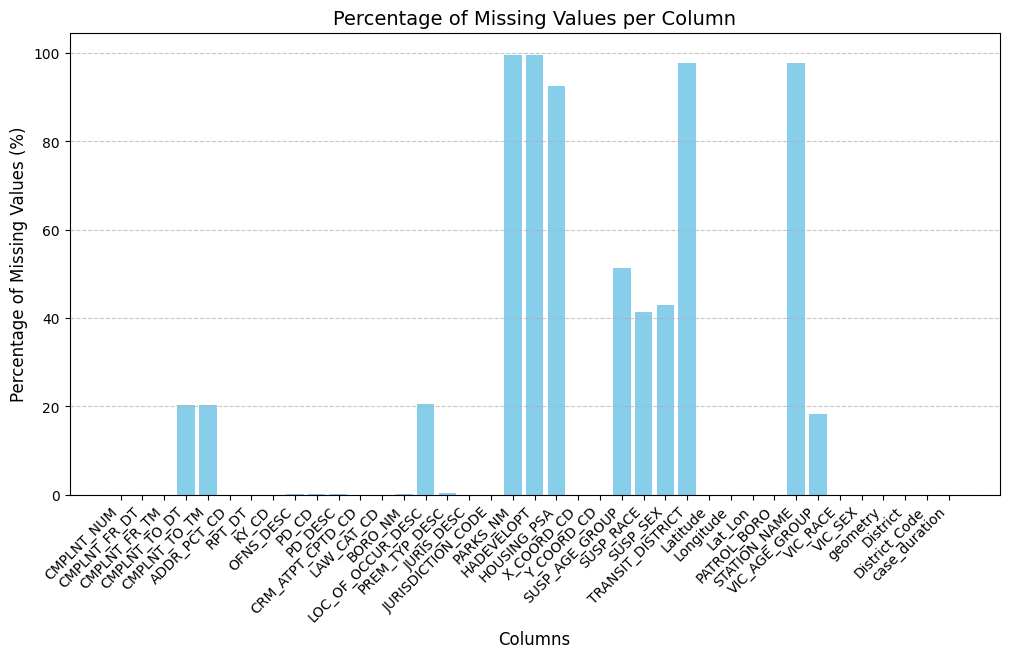

In [165]:
missing_percentage = (df.isna().sum() / len(df)) * 100

plt.figure(figsize=(12, 6))
plt.bar(missing_percentage.index, missing_percentage.values, color='skyblue')

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel("Percentage of Missing Values (%)", fontsize=12)
plt.xlabel("Columns", fontsize=12)
plt.title("Percentage of Missing Values per Column", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


Missing values seem to correspond mainly to when the feature is not applicable.

In [39]:
df.isna().sum()

CMPLNT_NUM                 0
CMPLNT_FR_DT             828
CMPLNT_FR_TM              48
CMPLNT_TO_DT         1818964
CMPLNT_TO_TM         1813518
ADDR_PCT_CD              771
RPT_DT                     0
KY_CD                      0
OFNS_DESC              18886
PD_CD                   7593
PD_DESC                 7593
CRM_ATPT_CPTD_CD         168
LAW_CAT_CD                 0
BORO_NM                 7884
LOC_OF_OCCUR_DESC    1821966
PREM_TYP_DESC          39001
JURIS_DESC                 0
JURISDICTION_CODE          0
PARKS_NM             8877278
HADEVELOPT           8883190
HOUSING_PSA          8244451
X_COORD_CD               466
Y_COORD_CD               466
SUSP_AGE_GROUP       4583671
SUSP_RACE            3687178
SUSP_SEX             3820549
TRANSIT_DISTRICT     8716793
Latitude                 466
Longitude                466
Lat_Lon                  466
PATROL_BORO              587
STATION_NAME         8716793
VIC_AGE_GROUP        1623568
VIC_RACE                 671
VIC_SEX       

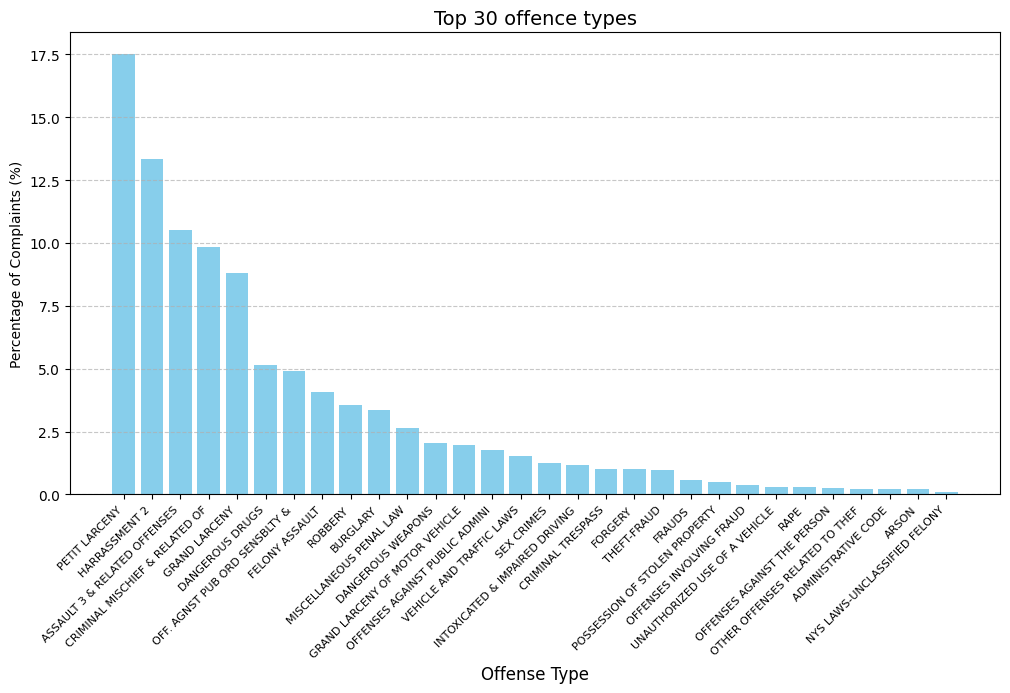

In [172]:
offense_percentage = (df['OFNS_DESC'].value_counts(normalize=True) * 100).head(30)

plt.figure(figsize=(12, 6))
plt.bar(offense_percentage.index, offense_percentage.values, color='skyblue')

plt.xticks(rotation=45, ha='right', fontsize=8)
plt.ylabel("Percentage of Complaints (%)", fontsize=10)
plt.xlabel("Offense Type", fontsize=12)
plt.title("Top 30 offence types", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


# Women centered analysis:

## Percentage of female victims:

In [173]:
df['VIC_SEX'].value_counts()

VIC_SEX
F    3485031
M    2970472
E    1292503
D    1160458
L       6062
Name: count, dtype: int64

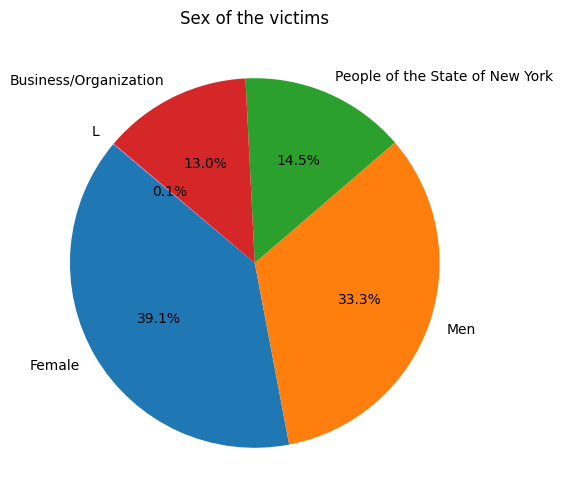

In [174]:
#F=Female
#M=Male
#E=PSNY/People of the State of New York
#D=Business/Organization,


labels= ["Female", "Men", "People of the State of New York", "Business/Organization", "L"]
sizes = df['VIC_SEX'].value_counts()
#sizes["Unknown"] = df["VIC_SEX"].isna().sum()

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Sex of the victims')
plt.show()

Now taking only when victim is a single person

In [175]:
df_gender = df.query("(VIC_SEX == 'F')| (VIC_SEX =='M')")

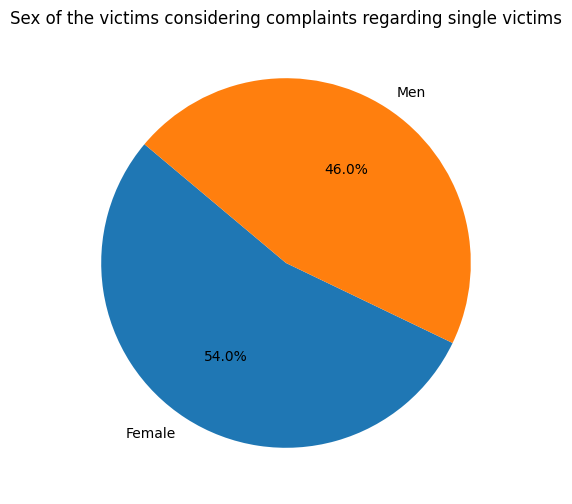

In [176]:
labels= ["Female", "Men"]
sizes = [df_gender['VIC_SEX'].value_counts().get('F', 0),
         df_gender['VIC_SEX'].value_counts().get('M', 0)]


plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Sex of the victims considering complaints regarding single victims')
plt.show()

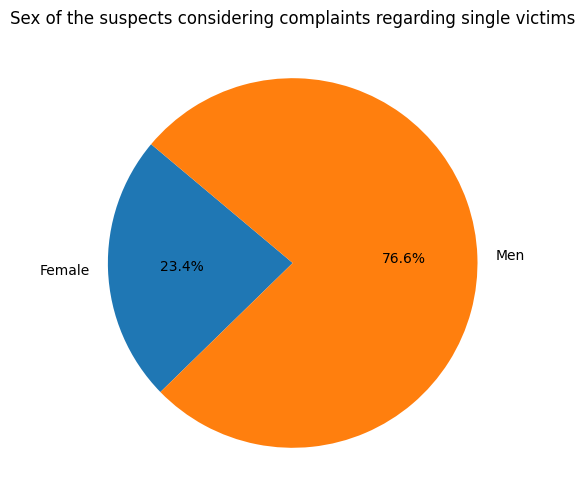

In [177]:
df_gender_susp = df[df['SUSP_SEX'].isin(['F', 'M'])]

labels= ["Female", "Men"]
sizes = [df_gender_susp['SUSP_SEX'].value_counts().get('F', 0),
         df_gender_susp['SUSP_SEX'].value_counts().get('M', 0)]


plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Sex of the suspects considering complaints regarding single victims')
plt.show()

## Types of crimes women and men are victim of:

In [45]:
women_victims = df_gender.query("VIC_SEX == 'F'")
men_victims = df_gender.query("VIC_SEX == 'M'")

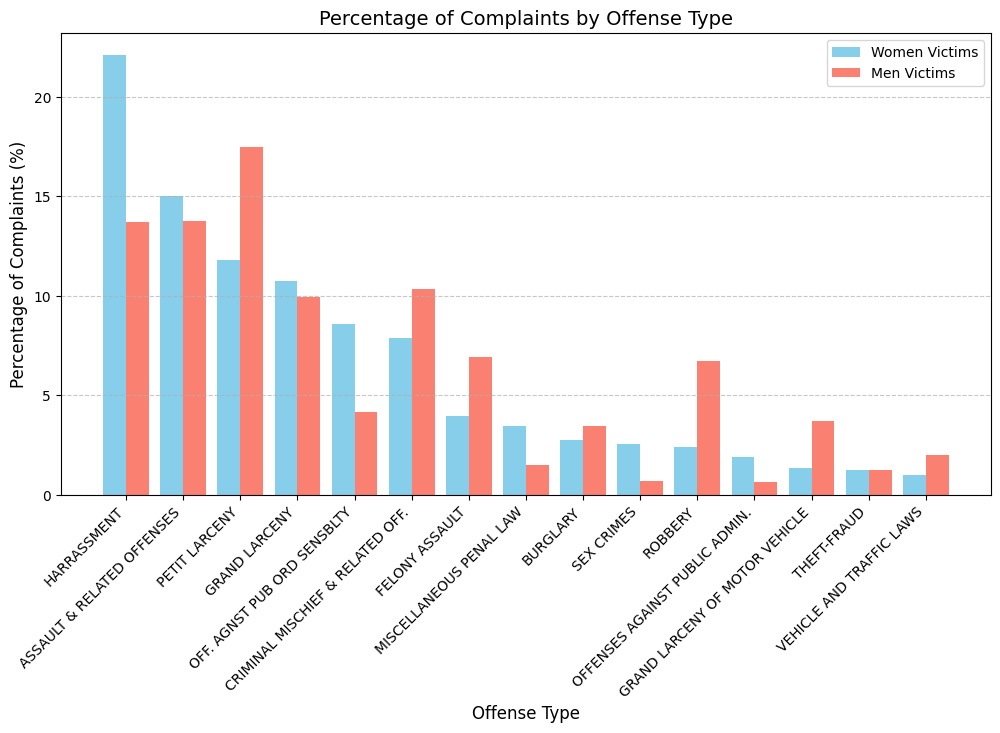

In [179]:
import matplotlib.pyplot as plt

def rename_dict_key(oldkey, newkey, dict):
    dict[newkey] = dict[oldkey]
    del dict[oldkey]

# Get top 15 offenses for women victims in percentage
top_women_offenses = women_victims['OFNS_DESC'].value_counts(normalize=True)[:15] * 100

# Get offense counts for men victims in percentage
men_offense_counts = men_victims['OFNS_DESC'].value_counts(normalize=True) * 100

# Align men’s offenses with the top 15 women’s offenses
men_percentages = men_offense_counts.reindex(top_women_offenses.index).fillna(0)
rename_dict_key('HARRASSMENT 2','HARRASSMENT',top_women_offenses)
rename_dict_key('ASSAULT 3 & RELATED OFFENSES','ASSAULT & RELATED OFFENSES',top_women_offenses)
rename_dict_key('OFF. AGNST PUB ORD SENSBLTY &', 'OFF. AGNST PUB ORD SENSBLTY',top_women_offenses)
rename_dict_key('CRIMINAL MISCHIEF & RELATED OF', 'CRIMINAL MISCHIEF & RELATED OFF.',top_women_offenses)
rename_dict_key('OFFENSES AGAINST PUBLIC ADMINI', 'OFFENSES AGAINST PUBLIC ADMIN.', top_women_offenses)

rename_dict_key('HARRASSMENT 2','HARRASSMENT',men_percentages)
rename_dict_key('ASSAULT 3 & RELATED OFFENSES','ASSAULT & RELATED OFFENSES',men_percentages)
rename_dict_key('OFF. AGNST PUB ORD SENSBLTY &', 'OFF. AGNST PUB ORD SENSBLTY',men_percentages)
rename_dict_key('CRIMINAL MISCHIEF & RELATED OF', 'CRIMINAL MISCHIEF & RELATED OFF.',men_percentages)
rename_dict_key('OFFENSES AGAINST PUBLIC ADMINI', 'OFFENSES AGAINST PUBLIC ADMIN.', men_percentages)

# Sort top offenses for women victims
top_women_offenses = top_women_offenses.sort_values(ascending=False)
men_percentages = men_percentages.reindex(top_women_offenses.index).fillna(0)

# Plot grouped bar chart
plt.figure(figsize=(12, 6))
bar_width = 0.4
x_labels = top_women_offenses.index
x = range(len(x_labels))

plt.bar(x, top_women_offenses.values, width=bar_width, label="Women Victims", color='skyblue', align='center')
plt.bar([i + bar_width for i in x], men_percentages.values, width=bar_width, label="Men Victims", color='salmon', align='center')

plt.xticks([i + bar_width / 2 for i in x], x_labels, rotation=45, ha="right", fontsize=10)

plt.ylabel("Percentage of Complaints (%)", fontsize=12)
plt.xlabel("Offense Type", fontsize=12)
plt.title("Percentage of Complaints by Offense Type", fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig('men_vs_women_victims.png', bbox_inches='tight')

plt.show()

## Types of crimes women and men are suspected of:

In [183]:
women_suspect = df_gender.query("SUSP_SEX == 'F'")
men_suspect = df_gender.query("SUSP_SEX == 'M'")

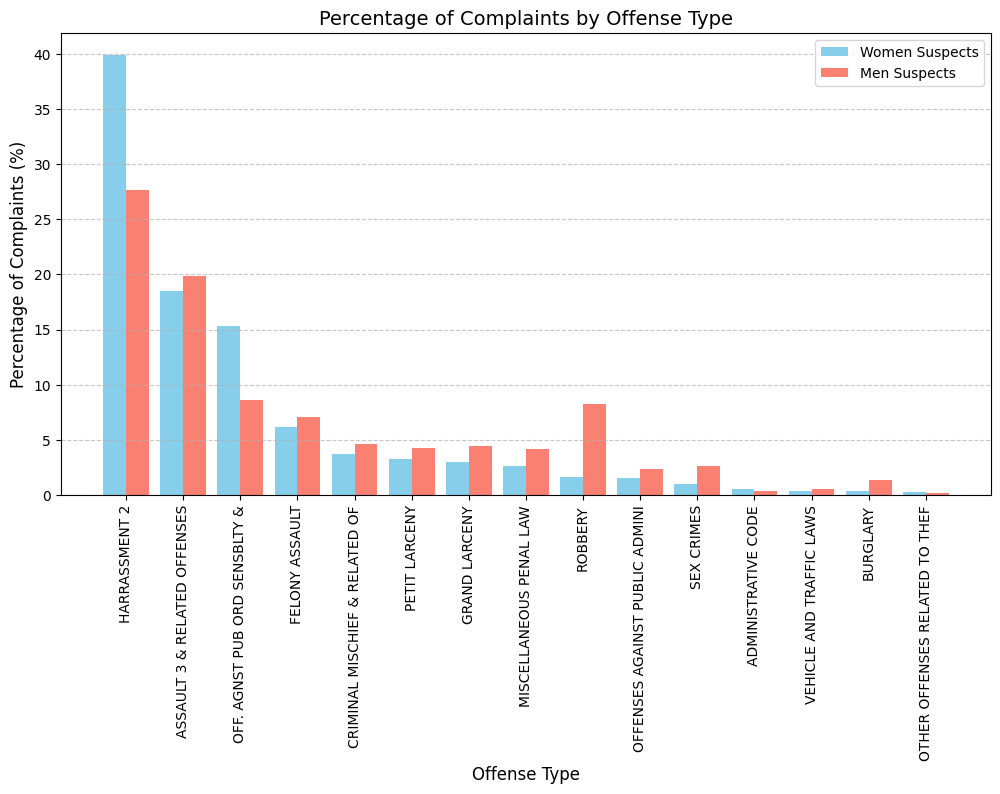

In [184]:
top_women_offenses = women_suspect['OFNS_DESC'].value_counts(normalize=True)[:15] * 100

men_offense_counts = men_suspect['OFNS_DESC'].value_counts(normalize=True) * 100

men_percentages = men_offense_counts.reindex(top_women_offenses.index).fillna(0)

plt.figure(figsize=(12, 6))
bar_width = 0.4
x_labels = top_women_offenses.index
x = range(len(x_labels))

plt.bar(x, top_women_offenses.values, width=bar_width, label="Women Suspects", color='skyblue', align='center')
plt.bar([i + bar_width for i in x], men_percentages.values, width=bar_width, label="Men Suspects", color='salmon', align='center')

plt.xticks([i + bar_width / 2 for i in x], x_labels, rotation=90, fontsize=10)
plt.ylabel("Percentage of Complaints (%)", fontsize=12)
plt.xlabel("Offense Type", fontsize=12)
plt.title("Percentage of Complaints by Offense Type", fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## Dangerous hours for men VS women:

{'07': 90568, '22': 157384, '03': 68666, '15': 209274, '19': 189150, '20': 189036, '23': 143145, '21': 170905, '06': 54867, '01': 102630, '11': 152708, '18': 202099, '00': 158818, '14': 185629, '08': 145743, '12': 211924, '05': 48380, '17': 196380, '02': 82676, '13': 167958, '16': 193217, '10': 153762, '09': 151904, '04': 58187}


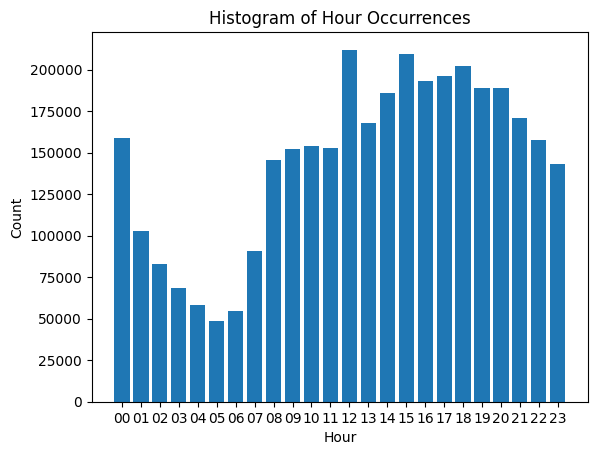

In [ ]:
hours=women_victims['CMPLNT_FR_TM'].str[:2]
hours=hours[~(hours=='(n')]
hours_dict=hours.value_counts(sort=False).to_dict()
print(hours_dict)
hours_sorted = dict(sorted(hours_dict.items(), key=lambda x: int(x[0])))

plt.bar(hours_sorted.keys(), hours_sorted.values())
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Histogram of Hour Occurrences")
plt.show()

{'22': 116603, '06': 42149, '19': 129419, '23': 108043, '01': 84824, '11': 102535, '00': 107721, '14': 125555, '12': 125822, '17': 131969, '21': 125143, '05': 43937, '20': 132042, '18': 133891, '15': 141403, '13': 112549, '16': 132695, '07': 58245, '10': 97962, '08': 84632, '04': 58325, '03': 64054, '02': 72738, '09': 89316}


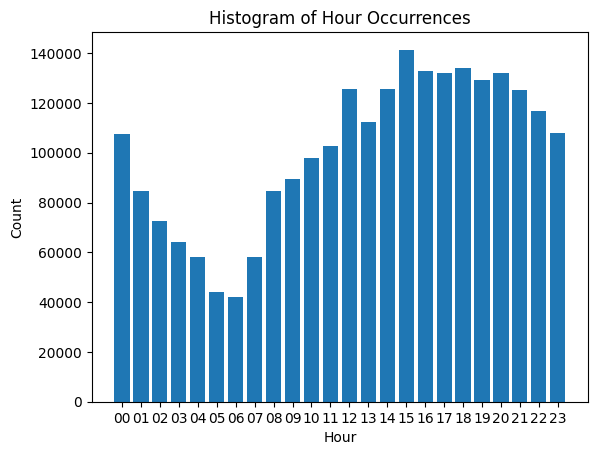

In [ ]:
hours=men_suspect['CMPLNT_FR_TM'].str[:2]
hours=hours[~(hours=='(n')]
hours_dict=hours.value_counts(sort=False).to_dict()
print(hours_dict)
hours_sorted = dict(sorted(hours_dict.items(), key=lambda x: int(x[0])))

plt.bar(hours_sorted.keys(), hours_sorted.values())
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Histogram of Hour Occurrences")
plt.show()

# How did crime evolve through the years

In [ ]:
df["year_begin"] = df['CMPLNT_FR_DT'].dt.year

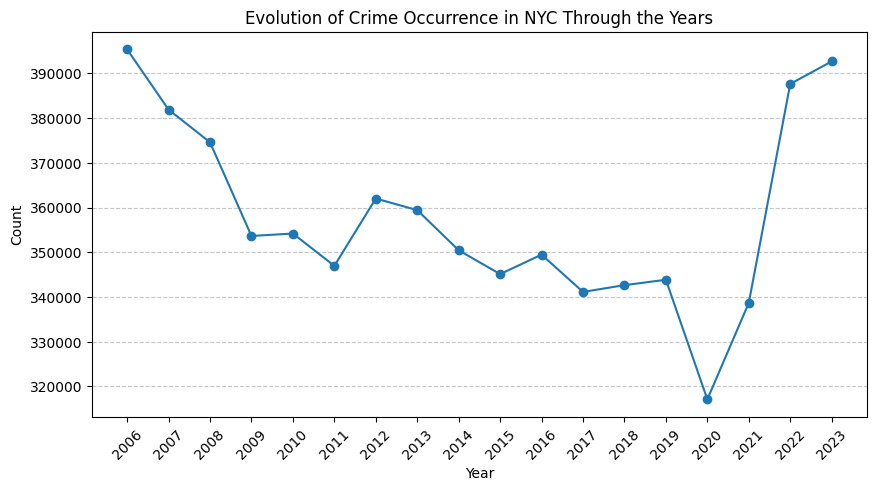

In [ ]:
import matplotlib.pyplot as plt
df_gender['CMPLNT_FR_DT'] = pd.to_datetime(df_gender['CMPLNT_FR_DT'], format='%m/%d/%Y', errors='coerce')
df_gender["year_begin"] = df_gender['CMPLNT_FR_DT'].dt.year  # Ensure year is extracted properly

df_year = df_gender.groupby('year_begin').agg(
    nb_crimes=('year_begin', 'size')
).reset_index()

df_year['year_begin'] = pd.to_numeric(df_year['year_begin'], errors='coerce').astype('Int64')
#Crop from 2006 not enough data
df_year = df_year.query("year_begin >= 2006")

plt.figure(figsize=(10, 5))

# Line plot with dots at each year
plt.plot(df_year["year_begin"], df_year["nb_crimes"], marker='o', linestyle='-')

# X-axis labels: show every year, rotate for readability
plt.xticks(df_year["year_begin"], rotation=45)

plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Evolution of Crime Occurrence in NYC Through the Years")

plt.grid(axis="y", linestyle="--", alpha=0.7)  # Optional grid for readability
plt.show()


Interesting result. A drop in 2020 during covid, then a huge increase.

## Main offences targetting "People of the State of New York" and "organization"

In [185]:
#F=Female
#M=Male
#E=PSNY/People of the State of New York
#D=Business/Organization,
#L

df_E = df.query("VIC_SEX == 'E'")
print(df_E["OFNS_DESC"].value_counts().head(10))

OFNS_DESC
DANGEROUS DRUGS                   450516
DANGEROUS WEAPONS                 161599
CRIMINAL MISCHIEF & RELATED OF    120437
INTOXICATED & IMPAIRED DRIVING     98051
OFFENSES AGAINST PUBLIC ADMINI     68632
FORGERY                            67740
MISCELLANEOUS PENAL LAW            56832
CRIMINAL TRESPASS                  49281
VEHICLE AND TRAFFIC LAWS           40928
OFFENSES INVOLVING FRAUD           19597
Name: count, dtype: int64


In [186]:
df_D = df.query("VIC_SEX == 'D'")
print(df_D["OFNS_DESC"].value_counts().head(10))

OFNS_DESC
PETIT LARCENY                     615630
CRIMINAL MISCHIEF & RELATED OF    174540
GRAND LARCENY                     112179
BURGLARY                           96305
ROBBERY                            30825
GRAND LARCENY OF MOTOR VEHICLE     14840
CRIMINAL TRESPASS                  14480
POSSESSION OF STOLEN PROPERTY      12885
OFFENSES INVOLVING FRAUD           11443
FORGERY                            11205
Name: count, dtype: int64


# Complaints by borough

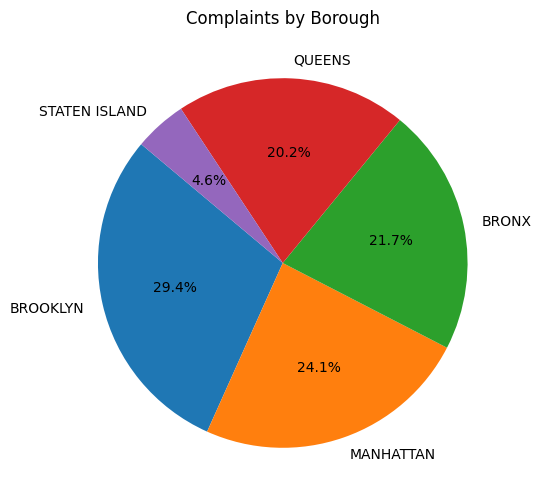

In [187]:
sizes = df['BORO_NM'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=sizes.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Complaints by Borough')
plt.show()

# Economic situation NYC

The required dataset was obtain from: https://data.cccnewyork.org/data/download#0,8/66

In [115]:
folder_eco = data_folder + 'data_eco/'
df_poverty = pd.read_csv(folder_eco+'Poverty.csv', sep=',', skiprows=4)
df_poverty = df_poverty.rename(columns={'Data': 'individuals_below_FPL'})
df_poverty = df_poverty.rename(columns={'TimeFrame': 'Year'})
df_poverty = df_poverty.rename(columns={'Location': 'District'})
df_poverty = df_poverty.query("DataFormat  == 'Percent'").reset_index()
df_poverty.drop(["index","Fips","DataFormat"], axis=1, inplace =True)

In [116]:
df_poverty.head()

,District,Year,individuals_below_FPL
0,Battery Park/Tribeca,2011,0.07480
1,Greenwich Village,2011,0.07480
2,Lower East Side,2011,0.28605
3,Chelsea/Clinton,2011,0.13131
4,Midtown Business District,2011,0.13131


In [122]:
df2 = pd.read_csv(folder_eco+'Employment_Population_Ratio.csv', sep=',', skiprows=4)
df2 = df2.query("DataFormat == 'Percent'").reset_index()
df2 = df2.rename(columns={'Data': 'Employement_pop_ratio'})
df2 = df2.rename(columns={'TimeFrame': 'Year'})
df2 = df2.rename(columns={'Location': 'District'})
df2.drop(["index","Fips","DataFormat"], axis=1, inplace =True)

In [123]:
df2.head()

,District,Year,Employement_pop_ratio
0,Battery Park/Tribeca,2005,0.751
1,Greenwich Village,2005,0.751
2,Lower East Side,2005,0.564
3,Chelsea/Clinton,2005,0.677
4,Midtown Business District,2005,0.677


In [124]:
df_eco = pd.merge(df_poverty, 
                  df2, 
                  on=["District", "Year"],
                  how='outer')

In [125]:
df_eco.head()
df_eco.to_csv(data_folder + "eco_data.csv", index=False)

In [126]:
df_eco = pd.read_csv(data_folder+'eco_data.csv')
df_eco.head()

,District,Year,individuals_below_FPL,Employement_pop_ratio
0,Astoria,2005,0.18347,0.593
1,Astoria,2006,0.17182,0.592
2,Astoria,2007,0.16717,0.603
3,Astoria,2008,0.16424,0.638
4,Astoria,2009,0.15914,0.608


# Data Analysis of social economic conditions

In [129]:
df_eco_by_district = df_eco.groupby('District').agg(
                    individuals_below_FPL_mean = ('individuals_below_FPL', 'mean'),
                    individuals_below_FPL_std = ('individuals_below_FPL', 'std'),
                    Employement_pop_ratio_mean = ('Employement_pop_ratio', 'mean'),
                    Employement_pop_ratio_std = ('Employement_pop_ratio', 'std'),
).reset_index()

df_eco_by_district.head()


,District,individuals_below_FPL_mean,individuals_below_FPL_std,Employement_pop_ratio_mean,Employement_pop_ratio_std
0,Astoria,0.162306,0.023624,0.636647,0.032357
1,Battery Park/Tribeca,0.082432,0.013163,0.695889,0.106929
2,Bay Ridge,0.150456,0.021060,0.569882,0.022872
3,Bayside,0.075327,0.015086,0.586118,0.015763
4,Bedford Park,0.306933,0.032506,0.552941,0.033366


In [143]:
def plot_top_bottom_n(df, value_col, error_col, label_y, n=10, best=True):
    """
    Plots a bar chart with error bars for the top or bottom n values of a given column.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    value_col (str): The column name to plot (mean values).
    error_col (str): The column name for error bars (standard deviation values).
    n (int): The number of best or worst values to display.
    best (bool): If True, plot the top n values; if False, plot the bottom n values.
    """
    df_sorted = df.sort_values(by=value_col, ascending=not best).head(n)
    
    color = "red" if best else "green"
    plt.figure(figsize=(10, 6))
    plt.bar(df_sorted['District'], df_sorted[value_col], yerr=df_sorted[error_col], capsize=5, alpha=0.7, color=color)
    
    plt.xlabel('District')
    plt.ylabel(label_y)
    plt.title(f"{'Top' if best else 'Bottom'} {n} Districts by {label_y}")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    plt.show()

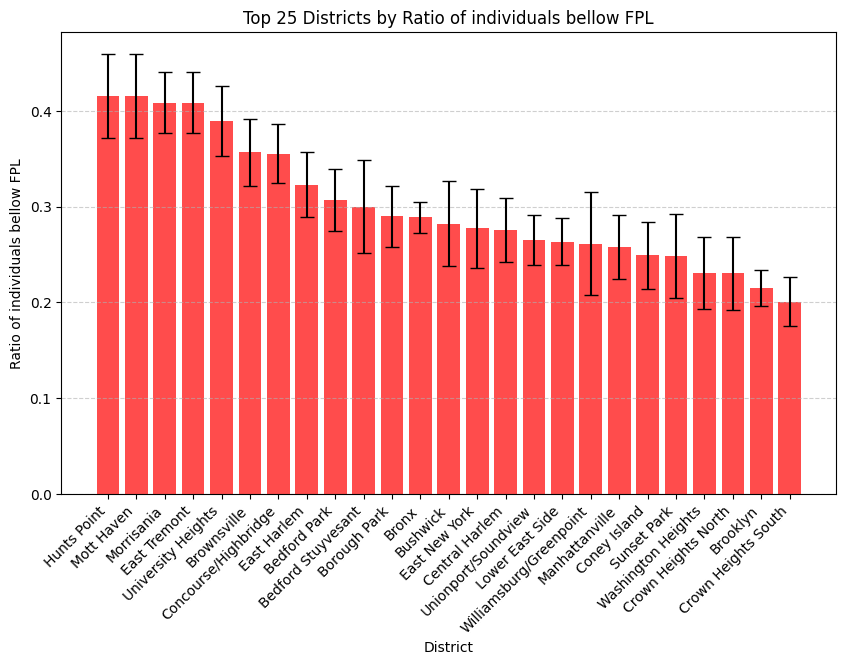

In [155]:
label_y = "Ratio of individuals bellow FPL"
plot_top_bottom_n(df_eco_by_district, "individuals_below_FPL_mean", "individuals_below_FPL_std", label_y, n=25, best=True)

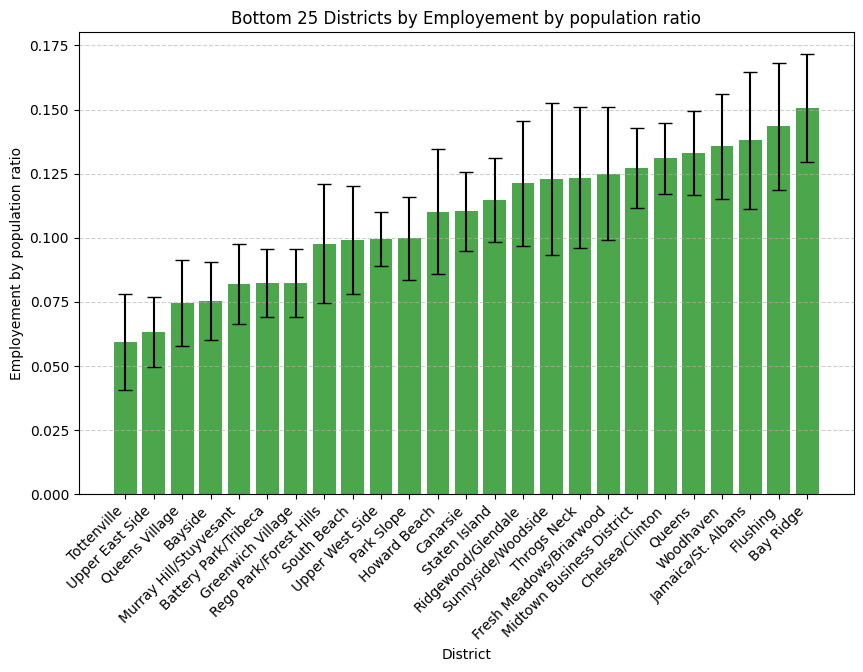

In [154]:
plot_top_bottom_n(df_eco_by_district, "individuals_below_FPL_mean", "individuals_below_FPL_std", label_y, n=25, best=False)

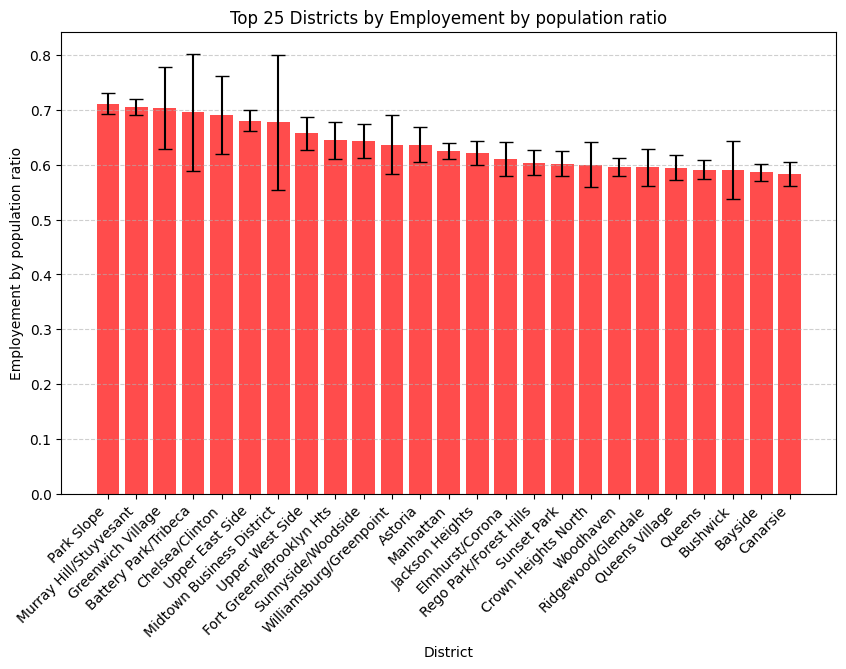

In [158]:
label_y = "Employement by population ratio"
plot_top_bottom_n(df_eco_by_district, "Employement_pop_ratio_mean", "Employement_pop_ratio_std", label_y, n=25, best=True)

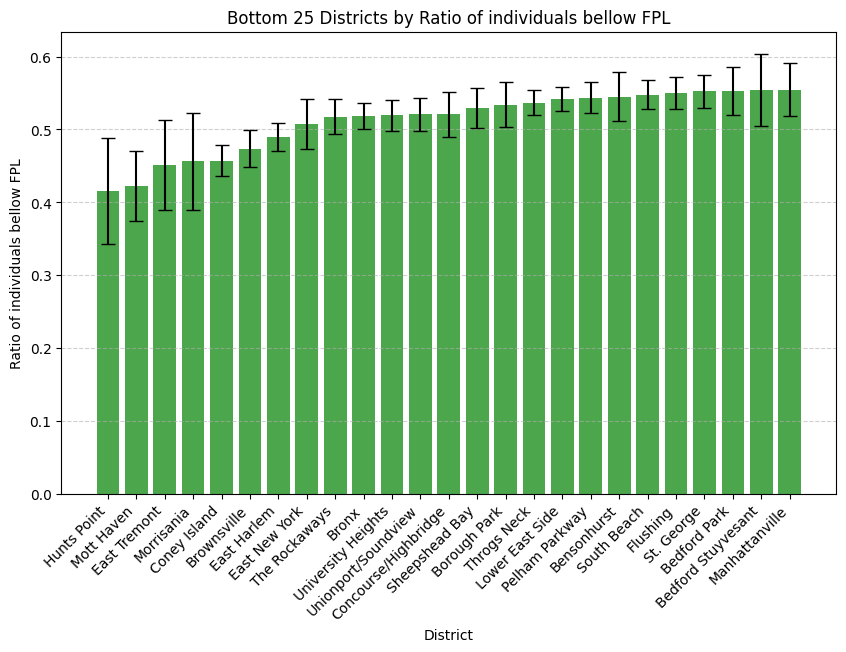

In [156]:
plot_top_bottom_n(df_eco_by_district, "Employement_pop_ratio_mean", "Employement_pop_ratio_std", label_y, n=25, best=False)